<a href="https://colab.research.google.com/github/seyunkim0114/Deep-Learning/blob/main/LinearClassifierProbes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Seyun Kim
# 2020 ECE469 Deep Learning Midterm
# Reproducing figure 2 presented in "Understanding intermediate layers using linear classifier probes"

In [ ]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
import keras
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras import optimizers, regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [ ]:
# parameters
row = 28
col = 28
layerNum = 0

In [ ]:
# hyperparameters
lr = 0.01
batch_size = 128
weight_decay = 0.1

In [ ]:
# Load data
(x_data, y_data), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Pre-process data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size =1/6)

x_train = np.reshape(x_train, (50000, row, col, 1))
x_val = np.reshape(x_val, (10000, row, col, 1))
x_test = np.reshape(x_test, (10000, row, col, 1))
input_shape = (row, col ,1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Normalization
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [ ]:
# Make label one hot encoded
digits = 10
y_train = keras.utils.to_categorical(y_train, num_classes = digits)
y_data = keras.utils.to_categorical(y_data, num_classes = digits)

y_val = keras.utils.to_categorical(y_val, num_classes = digits)
y_test = keras.utils.to_categorical(y_test, num_classes = digits)

In [ ]:
# Function to add linear classifier probes
# stop_gradient prevents probe layer from backpropating to the model
def addProbe(feature, models, name):
  x = Flatten()(tf.stop_gradient(feature))
  x = Dense(10, activation = 'softmax')(x)
  #models.append(Model(input, x))
  models[name] = Model(input, x)

In [ ]:
datagen = ImageDataGenerator(
    #rotation_range = 15,
    width_shift_range=3,
    height_shift_range=3,
    #horizontal_flip=True,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    shear_range = 0.2
    )
datagen.fit(x_train)

In [ ]:
def lr_scheduler(epoch):
    l = lr
    if epoch > 15:
        l = 0.001
    if epoch > 60:
        l = 0.0005
    if epoch > 100:
        l = 0.0001
    return l

In [ ]:
# Function to get loss of each probe
# try using softmax crossentropy. use int_layer parameter to save model output layer
def process_probe(modelname, list_pretrain, name):
  modelname.compile(loss="categorical_crossentropy", 
                    optimizer=keras.optimizers.RMSprop(learning_rate = lr, decay=1e-3), 
                    metrics=["accuracy"])
  
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

  modelname.fit(datagen.flow(x_train, y_train, batch_size = 128),
                steps_per_epoch = x_train.shape[0] // 128,
                epochs = 150,
                verbose = 0,
                validation_data = (x_val, y_val),
                callbacks = [early_stop, LearningRateScheduler(lr_scheduler)]
                )
  score = modelname.evaluate(x_test, y_test, verbose = 0)
  print("=====================================================================================")
  print(name + ": Train stopped at epoch " + str(early_stop.stopped_epoch))
  print(name + ": Loss " + str(score[0]))
  print(name + ": Accuracy " + str(score[1]))
  print("=====================================================================================")
  list_pretrain.append(score[0])
  

In [ ]:
# Neural Network Model
probe_models = {}
post_train = []
probe_loss = []

input = Input(shape = x_train.shape[1:])
addProbe(input, probe_models, "input")

conv1_preact = Conv2D(32, [3,3])(input)
conv1_preact = Dropout(0.15)(conv1_preact)
addProbe(conv1_preact, probe_models, "conv1_preact")

conv1_postact = Activation('relu')(conv1_preact)
addProbe(conv1_postact, probe_models, "conv1_postact")

conv1_postpool = MaxPooling2D()(conv1_postact)
addProbe(conv1_postpool, probe_models, "conv1_postpool")

conv2_preact = Conv2D(32, [3,3])(conv1_postpool)
conv2_preact = Dropout(0.25)(conv2_preact)
addProbe(conv2_preact, probe_models, "conv2_preact")

conv2_postact = Activation('relu')(conv2_preact)
addProbe(conv2_postact, probe_models, "conv2_postact")

conv2_postpool = MaxPooling2D()(conv2_postact)
addProbe(conv2_postpool, probe_models, "conv2_postpool")

flat = Flatten()(conv2_postpool)

fc1_preact = Dense(256)(flat)
fc1_preact = Dropout(0.4)(fc1_preact)
addProbe(fc1_preact, probe_models, "fc1_pretact")

fc1_postact = Activation('relu')(fc1_preact)
#fc1_postact = Dropout(0.15)(fc1_postact)
addProbe(fc1_postact, probe_models, "fc1_postact")

logits = Dense(10)(fc1_postact)
logits = Dropout(0.25)(logits)
addProbe(logits, probe_models, "logits")

y = Activation('softmax')(logits)

model = Model(input, y)
model.summary()


In [ ]:
# Compute loss before training
loss_pretrain = []
for k,v in probe_models.items():
  process_probe(v, loss_pretrain, k)


In [ ]:
print(loss_pretrain)

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(), 
              metrics=["accuracy"]
              )


In [ ]:
model.fit(datagen.flow(x_train, y_train, 
          batch_size = batch_size),
          steps_per_epoch = x_train.shape[0] // batch_size,
          epochs = 10,
          verbose = 2,
          validation_data = (x_val, y_val)
          )

In [ ]:
print(model.evaluate(x_test, y_test)[0])

313/313 [==============================] - 1s 2ms/step - loss: 0.0231 - accuracy: 0.9934
0.02305186726152897


In [ ]:
loss_posttrain = []
for k,v in probe_models.items():
  process_probe(v, loss_posttrain, k)


In [ ]:
print(loss_posttrain)

Text(0.5, 1.0, 'After training for 10 epochs')

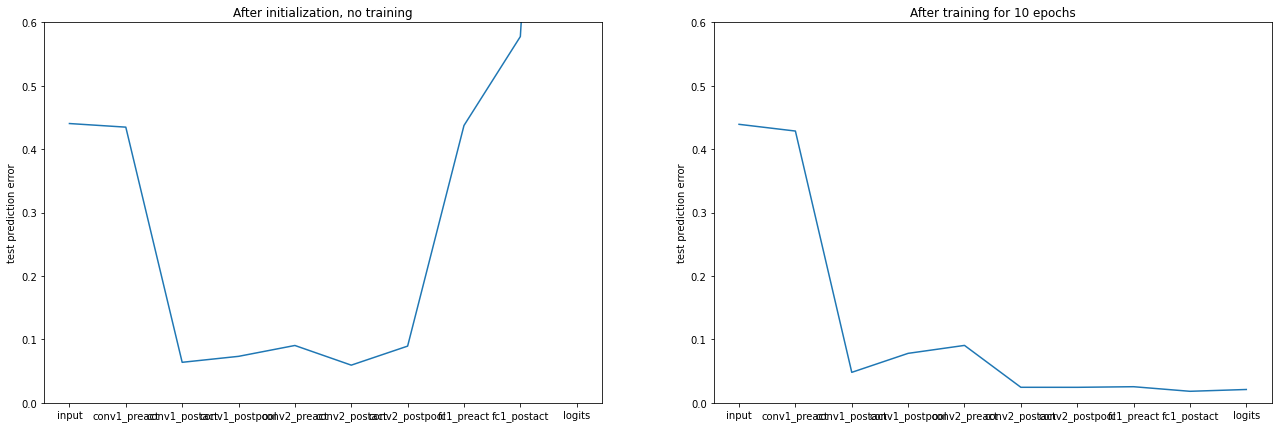

In [ ]:
# Plot
tick = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(22, 7))

plt.subplot(1,2,1)
plt.plot(loss_pretrain)
plt.xticks(tick, labels = ["input", "conv1_preact", "conv1_postact", "conv1_postpool", "conv2_preact", "conv2_postact", "conv2_postpool", "fc1_preact", "fc1_postact", "logits"])
plt.ylabel("test prediction error")
plt.ylim([0,0.6])
plt.title("After initialization, no training")

plt.subplot(1,2,2)
plt.plot(loss_posttrain)
plt.xticks(tick, labels = ["input", "conv1_preact", "conv1_postact", "conv1_postpool", "conv2_preact", "conv2_postact", "conv2_postpool", "fc1_preact", "fc1_postact", "logits"])
plt.ylabel("test prediction error")
plt.ylim([0,0.6])
plt.title("After training for 10 epochs")